In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
sys.path.insert(0, "../")
sys.path.insert(0, "../nohomers")

In [9]:
from nohomers.notebook.widgets import expand2square, image_labeller_widget, display_df_images
from nohomers.ml.torch_datasets import SimpleVisionExample, SimpleVisionDataset, split_train_valid_test, pil_loader
from nohomers.ml.lightweight_gan import get_trainer, generate_images
from nohomers.ml.cleaner import make_train_test_datasets, train_cleaner, make_network_input_from_images, load_cleaner, save_cleaner
from torch.utils.data import DataLoader
from torch.utils.data.dataloader import default_collate
import pandas as pd
import numpy as np
import torch
import torchvision
import pydash as py_
from tqdm import tqdm
from uuid import uuid4
from PIL import Image
from pathlib import Path
import json
import copy
import shutil
from multiprocessing.pool import ThreadPool
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [10]:
base_folder = Path("/mnt/evo/projects/nohomers/cleaners/simpsons_large_cleaned_nobackground_1024_augnormal04")
shutil.rmtree(base_folder)
dataset_folder = base_folder / "images"
dataset_folder.mkdir(parents=True, exist_ok=True)

In [11]:
trainer = get_trainer(
    models_dir="/mnt/evo/projects/metapedia/tmp/stylegan2/models", 
    name="simpsons_large_cleaned_nobackground_1024_augnormal04",
    load_from=65,
)

loading from version 0.12.4


# Label Results

In [12]:
num_examples = 1000
per_batch = 100
with ThreadPool(16) as pool:
    for batch in tqdm(range(0, num_examples, per_batch)):
        images = generate_images(trainer, per_batch)
        list(
            pool.imap(lambda x: x.image.save(dataset_folder / f"{uuid4()}.png"), images)
        )

100%|██████████| 10/10 [00:34<00:00,  3.49s/it]


In [13]:
images = list(dataset_folder.glob("*.png"))
labels = {}

In [47]:
to_label = py_.sample_size(images, 10)
image_labeller_widget(to_label, labels, ["N/A", "Good", "Bad"], image_size=(120, 120))

In [48]:
with open(dataset_folder / "labels.json", "w") as f:
    json.dump({
        p.name: label for p, label in labels.items()
    }, f)

# Create Training Dataset Objects

In [49]:
examples = [SimpleVisionExample(path=p, label=(1 if l == "Good" else 0)) for p, l in labels.items()]
percent_positive = np.array([e.label for e in examples]).mean()
print(f"Num labelled={len(examples)}, Percent positive: {100 * percent_positive:.2f}%")

Num labelled=280, Percent positive: 56.07%


In [50]:
train_dataset, test_dataset = make_train_test_datasets(examples)

Dataset sizes train=226, valid=0, test=54


In [53]:
cleaner = train_cleaner(
    train_dataset, 
    test_dataset, 
    batch_size=50, 
    num_epochs=10, 
    device="cuda:0", 
    lr=0.001, 
    l2_reg=0.005, 
    clip_norm=0.5,
    workers=16,
)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]
Train Batch: 0it [00:00, ?it/s]
Train Batch: 1it [00:03,  3.98s/it]
Train Batch: 2it [00:04,  2.84s/it]
Train Batch: 3it [00:04,  2.04s/it]
Train Batch: 4it [00:04,  1.48s/it]
Train Batch: 5it [00:04,  1.06it/s]
Epoch:  10%|█         | 1/10 [00:07<01:07,  7.48s/it]

Epoch 0: train_loss=0.017, eval_loss=0.030



Train Batch: 0it [00:00, ?it/s]
Train Batch: 1it [00:03,  3.98s/it]
Train Batch: 2it [00:04,  2.84s/it]
Train Batch: 3it [00:04,  2.04s/it]
Train Batch: 4it [00:04,  1.48s/it]
Train Batch: 5it [00:04,  1.06it/s]
Epoch:  20%|██        | 2/10 [00:14<00:59,  7.45s/it]

Epoch 1: train_loss=0.020, eval_loss=0.025



Train Batch: 0it [00:00, ?it/s]
Train Batch: 1it [00:03,  3.95s/it]
Train Batch: 2it [00:04,  2.82s/it]
Train Batch: 3it [00:04,  2.03s/it]
Train Batch: 4it [00:04,  1.47s/it]
Train Batch: 5it [00:04,  1.06it/s]
Epoch:  30%|███       | 3/10 [00:22<00:52,  7.44s/it]

Epoch 2: train_loss=0.017, eval_loss=0.032



Train Batch: 0it [00:00, ?it/s]
Train Batch: 1it [00:03,  3.99s/it]
Train Batch: 2it [00:04,  2.85s/it]
Train Batch: 3it [00:04,  2.05s/it]
Train Batch: 4it [00:04,  1.49s/it]
Train Batch: 5it [00:04,  1.06it/s]
Epoch:  40%|████      | 4/10 [00:29<00:44,  7.44s/it]

Epoch 3: train_loss=0.012, eval_loss=0.026



Train Batch: 0it [00:00, ?it/s]
Train Batch: 1it [00:03,  3.95s/it]
Train Batch: 2it [00:04,  2.82s/it]
Train Batch: 3it [00:04,  2.03s/it]
Train Batch: 4it [00:04,  1.47s/it]
Train Batch: 5it [00:04,  1.07it/s]
Epoch:  50%|█████     | 5/10 [00:37<00:37,  7.42s/it]

Epoch 4: train_loss=0.015, eval_loss=0.022



Train Batch: 0it [00:00, ?it/s]
Train Batch: 1it [00:03,  3.95s/it]
Train Batch: 2it [00:04,  2.82s/it]
Train Batch: 3it [00:04,  2.02s/it]
Train Batch: 5it [00:04,  1.07it/s]
Epoch:  60%|██████    | 6/10 [00:44<00:29,  7.39s/it]

Epoch 5: train_loss=0.013, eval_loss=0.025



Train Batch: 0it [00:00, ?it/s]
Train Batch: 1it [00:03,  3.98s/it]
Train Batch: 2it [00:04,  2.84s/it]
Train Batch: 3it [00:04,  2.04s/it]
Train Batch: 5it [00:04,  1.07it/s]
Epoch:  70%|███████   | 7/10 [00:51<00:22,  7.38s/it]

Epoch 6: train_loss=0.011, eval_loss=0.022



Train Batch: 0it [00:00, ?it/s]
Train Batch: 1it [00:03,  3.97s/it]
Train Batch: 2it [00:04,  2.83s/it]
Train Batch: 3it [00:04,  2.03s/it]
Train Batch: 5it [00:04,  1.07it/s]
Epoch:  80%|████████  | 8/10 [00:59<00:14,  7.38s/it]

Epoch 7: train_loss=0.012, eval_loss=0.020



Train Batch: 0it [00:00, ?it/s]
Train Batch: 1it [00:03,  3.99s/it]
Train Batch: 2it [00:04,  2.85s/it]
Train Batch: 3it [00:04,  2.05s/it]
Train Batch: 4it [00:04,  1.49s/it]
Train Batch: 5it [00:04,  1.06it/s]
Epoch:  90%|█████████ | 9/10 [01:06<00:07,  7.41s/it]

Epoch 8: train_loss=0.012, eval_loss=0.022



Train Batch: 0it [00:00, ?it/s]
Train Batch: 1it [00:04,  4.03s/it]
Train Batch: 2it [00:04,  2.88s/it]
Train Batch: 3it [00:04,  2.07s/it]
Train Batch: 4it [00:04,  1.50s/it]
Train Batch: 5it [00:04,  1.05it/s]
Epoch: 100%|██████████| 10/10 [01:14<00:00,  7.41s/it]

Epoch 9: train_loss=0.010, eval_loss=0.020
Loading best eval 0.019711514934897423 from epoch 9


In [54]:
save_cleaner(cleaner, base_folder / "cleaner.pkl")

In [ ]:
cleaner = load_cleaner(base_folder / "cleaner.pkl")

## Train Scoring Model

In [56]:
to_score = list(dataset_folder.glob("*.png"))
score_batch_size = 100
with ThreadPool(16) as pool:
    scores = []
    for batch_paths in tqdm(py_.chunk(to_score, score_batch_size), "Batches"):
        batch = make_network_input_from_images(list(pool.imap(lambda x: pil_loader(x), batch_paths))).cuda()
        batch_scores = cleaner.forward(batch)
        probs = torch.nn.Softmax(dim=1)(batch_scores)
        scores.extend([p[1].item() for p in probs])

scored_df = pd.DataFrame(dict(
    path=[str(e) for e in to_score],
    score=scores,
))

Batches: 100%|██████████| 10/10 [00:09<00:00,  1.08it/s]


In [59]:
scored_df["score"].quantile([0.25, 0.5, 0.75])

0.25    0.310693
0.50    0.493495
0.75    0.678696
Name: score, dtype: float64

,path,score
379,,0.914231
733,,0.907333
901,,0.890502
576,,0.852821
776,,0.849334
173,,0.843159
284,,0.814573
210,,0.799447
229,,0.770652
462,,0.764038

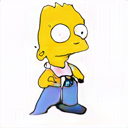
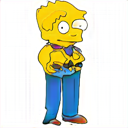
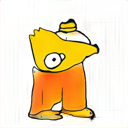
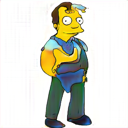
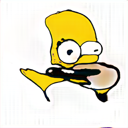
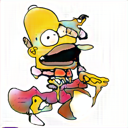
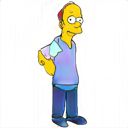
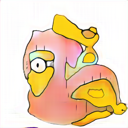
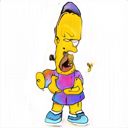
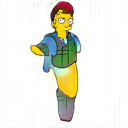
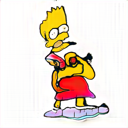
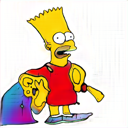
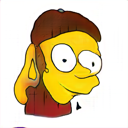
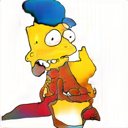
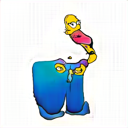
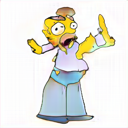
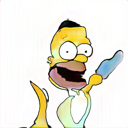
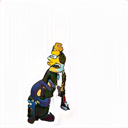
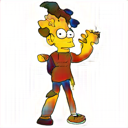
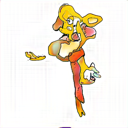
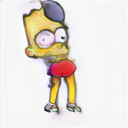
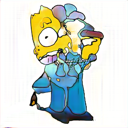
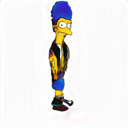
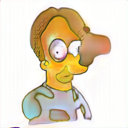
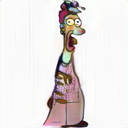
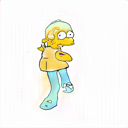
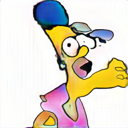
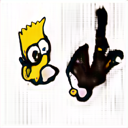
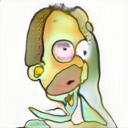
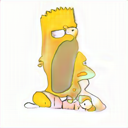
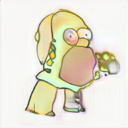
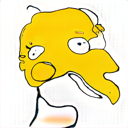
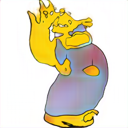
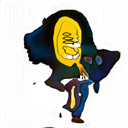
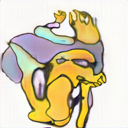
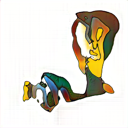
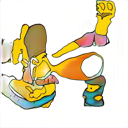
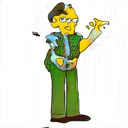
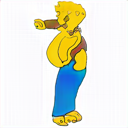
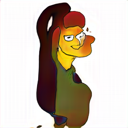
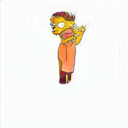
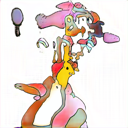
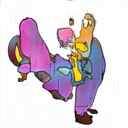
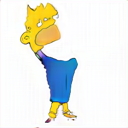
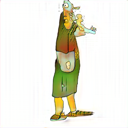
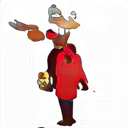
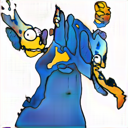
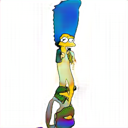
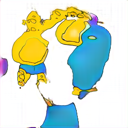
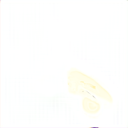

In [61]:
display_df_images(scored_df.sample(50).sort_values("score", ascending=False))